In [1]:
import requests


overpass_url = "http://overpass-api.de/api/interpreter"

#  в Гамбурге
overpass_query = """
[out:json];
area[name="Hamburg"]->.searchArea;
(
  node(area.searchArea)["highway"="bus_stop"];
  node(area.searchArea)["public_transport"="platform"];
  node(area.searchArea)["railway"="tram_stop"];
  node(area.searchArea)["amenity"="bus_station"];
);
out body;
"""
response = requests.get(overpass_url, params={'data': overpass_query})
data = response.json()

num_stops = len(data['elements'])
print(f"Total number of public transport stops in Hamburg: {num_stops}")

Total number of public transport stops in Hamburg: 4432


In [2]:
import pandas as pd

stops = pd.DataFrame(data['elements'])
print(stops.head())

   type        id        lat        lon  \
0  node  10864685  53.461987   9.854455   
1  node  15585299  53.618554  10.073168   
2  node  21560119  53.477998  10.239488   
3  node  21665446  53.590613  10.178648   
4  node  21764350  53.468268   9.967514   

                                                tags  
0  {'bench': 'no', 'bin': 'no', 'bus': 'yes', 'hi...  
1  {'bench': 'yes', 'bin': 'yes', 'highway': 'bus...  
2  {'bench': 'no', 'bin': 'yes', 'bus': 'yes', 'h...  
3  {'bus': 'yes', 'highway': 'bus_stop', 'name': ...  
4  {'bench': 'yes', 'bin': 'yes', 'bus': 'yes', '...  


In [3]:
# Получение типов остановок
stop_types = stops['tags'].apply(lambda tags: tags.get('highway', tags.get('public_transport', tags.get('railway', tags.get('amenity')))))
stop_type_counts = stop_types.value_counts()

print(stop_type_counts)

tags
bus_stop             4365
platform               62
construction            2
bus_stop;platform       2
station                 1
Name: count, dtype: int64


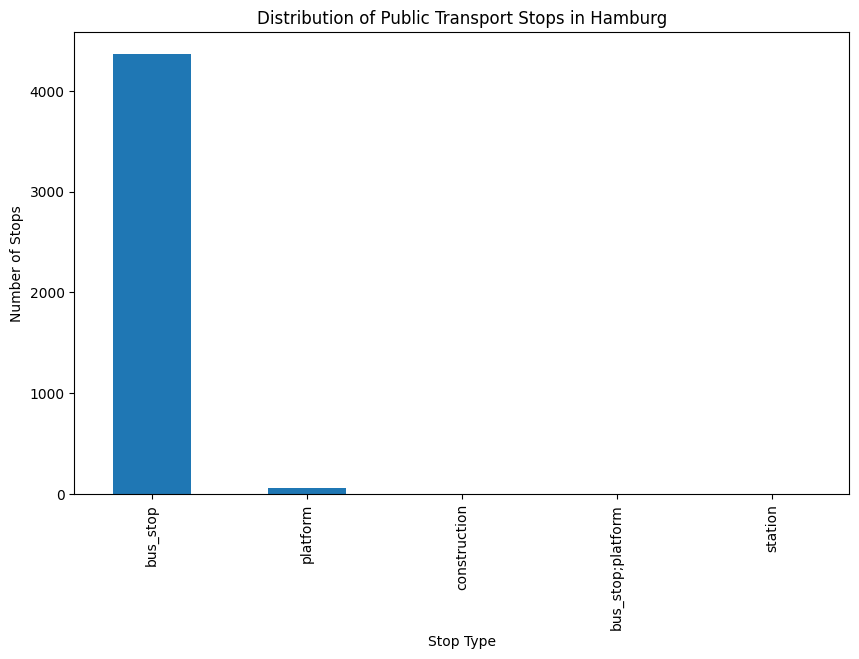

In [4]:
import matplotlib.pyplot as plt

# Построение графика распределения типов остановок
plt.figure(figsize=(10, 6))
stop_type_counts.plot(kind='bar')
plt.title('Distribution of Public Transport Stops in Hamburg')
plt.xlabel('Stop Type')
plt.ylabel('Number of Stops')
plt.show()

In [8]:
import requests
import geopandas as gpd
from shapely.geometry import Point
import folium

overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area[name="Hamburg"]->.searchArea;
(
  node(area.searchArea)["highway"="bus_stop"];
  node(area.searchArea)["public_transport"="platform"];
  node(area.searchArea)["railway"="tram_stop"];
  node(area.searchArea)["amenity"="bus_station"];
);
out body;
"""
response = requests.get(overpass_url, params={'data': overpass_query})
response.raise_for_status()
data = response.json()

stops = gpd.GeoDataFrame(
    data['elements'],
    geometry=[Point(stop['lon'], stop['lat']) for stop in data['elements']],
    crs="EPSG:4326"
)


districts_file_path = "/content/export.geojson"
districts = gpd.read_file(districts_file_path)


districts['num_stops'] = districts.apply(
    lambda row: stops.within(row['geometry']).sum(),
    axis=1
)


m = folium.Map(location=[53.5511, 9.9937], zoom_start=11)
folium.GeoJson(districts).add_to(m)


for _, stop in stops.iterrows():
    folium.CircleMarker(
        location=[stop.geometry.y, stop.geometry.x],
        radius=2,
        color='blue',
        fill=True,
        fill_color='blue'
    ).add_to(m)


for _, district in districts.iterrows():
    folium.Marker(
        location=[district.geometry.centroid.y, district.geometry.centroid.x],
        popup=f"{district['name']}: {district['num_stops']} stops"
    ).add_to(m)


m.save("stops_coordinates.csv")


m